# Why do deprivation and inequality produce high crime and low trust? Model explorer

This notebook provides a simple way to explore main results from our model. Users can (a) compute and visualize an optimal policy for any combination of parameters; 
and: 
(b) run a simulation for any combination of parameters and see the evolution of behaviour


In [ ]:
### IMPORT AND DEFINE FUNCTIONS

#Just run this cell once and do not change anything

#Load the packages

from scipy.stats import norm
from scipy.special import binom as binom_coef
import multiprocessing as mtp # Parts of the code are parallelized, make sure your configuration allows it
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from tqdm import tqdm_notebook as tqdm

#Set initial values for the environment parameters; these are the defaults that will apply unless otherwise stated
x = 1 # cost of cooperation
Sigma = 2 # variance of resources in the population
mu = 1 # mean resources in the population
r = 0.1 # Social mobility
alpha = 1.2 # Cooperation efficiency
omega = 5 # Fitness impact of being under the desperation threshold
possible_states = np.round(np.linspace(-50,50,1001),1) # Discrete pace of the possible resource values (from -50 to 50)
gamma = 1/3 # Probability of punishment for exploiters
beta = 5 # resources for successfully exploiting
pi = 10 # Size of punishment in resources
n = 5 # Interaction group size
g = 100 # g is the number of groups, so population size N = g *n
K = 50 # the size of the sample observed by an agent to estimate p

## Define the dynamic programming function

# An agent is defined by a level of resources, which is a state variable and referred to as 'state' in what follows. 
#At each time step, the state changes both by stochasticity and as a consequence of his action. 
#The code below provides the algorithm to seek the optimal action policy, i.e. the optimal action for each value of state (level of resources).

## Some subfunctions first

# This function creates a discretized normal distribution
# It returns the probabilities of being at state x (which can be a vector),
# if the expectancy is loc (also possibly a vector) and the s.d. scale
def norm_distrib(x,loc,scale=np.sqrt(1-(1-r)**2)*Sigma):
    x = np.array(x)
    loc = np.array(loc)
    x = np.tile(x,(loc.size,1))
    loc = np.tile(loc,(loc.size,1))
    z = (scale/np.sqrt(2*np.pi))*np.exp(-(x-loc.T)**2/(2*scale**2))
    return z/z.sum(1,keepdims=1)

# This function creates a probability transition matrix :
# it gives, for each state value, the probability to reach any other state value 
#("modif" is the increment due to the agent's action)
def probas(modif):
    z = (norm_distrib(x = possible_states,loc = ((1-r)*possible_states + r*mu + modif).clip(-50,+50),scale = np.sqrt(1-(1-r)**2)*Sigma))
    return(z)

#This function is just a shortcut to transform a state value into its position in the vector "possible_states"
def as_state(state):
    return(np.where(possible_states==state)[0][0])

# This is the crucial function: it runs a dynamic programming algorithm to compute the optimal decisions for given parameters
# p is the probability of cooperation being exploited
# T is the number of iterations (or the terminal time in dynamic programming slang; varying makes very little difference)
def dyn_prog(p,T=100):
    # We first associate each action with a transition probability matrix
    PROBAS_COOPERATE = p*probas(-x) + (1-p)*probas((alpha-1)*x)
    PROBAS_STEAL = gamma*probas(-pi) + (1-gamma)*probas(beta) # STEAL aka exploitation
    PROBAS_HIDE = probas(0) # HIDE here is short for foraging alone
    # We initiate empty arrays to record, for each state and each time, the optimal actions
    optimal_decisions = np.empty((T,possible_states.size), dtype='int8')
    # Idem for the fitness values
    Fitness = np.empty((T+1,possible_states.size))
    # This function simply extract, at time t, the fitness values for every state
    def fitness(t):
        return (Fitness[t,]-(possible_states<0)*omega).clip(0,)
    # We initiate the fitness vector at the terminal time T
    Fitness[T,] = (50+possible_states)/2
    for t in reversed(range(T)): # We loop over the time, to reach a convergent strategy
        # For each of the three actions, we compute a vector giving the expected fitness at each state
        s = np.dot(PROBAS_STEAL,fitness(t+1))
        h = np.dot(PROBAS_HIDE,fitness(t+1))
        c = np.dot(PROBAS_COOPERATE,fitness(t+1))
        # We combine the three fitness vectors
        fitnesss = np.array([s,h,c])
        # We compare the values at each state
        Fitness[t,] = np.max(fitnesss,axis=0) # the max becomes the fitness value at this state in time t
        optimal_decisions[t,] = np.argmax(fitnesss,axis=0) # the argmax is the optimal decision
    return(optimal_decisions[0],p,Fitness[0]) #We only return the strategy only at t = 0
    # If convergence takes place, it's the "long-term optimal strategy"


# shortcut functions to extract the agents the values of state, p, and the actions played, for all agents
def States(Z):
    return([Z.Pop[i].state for i in range(len(Z.Pop))])
def Trusts(Z):
    return([1-Z.Pop[i].social_distrust for i in range(len(Z.Pop))])
def Types(P):
    return([P.Pop[i].type for i in range(len(P.Pop))])
# Function to compute the effective social trust from the number of observed exploiters
def distrust(f):
    if f == K:
        return 1
    est = np.round(f/K*g*n)
    p = 1- binom_coef(g*n-est-1,n-1)/binom_coef(g*n-1,n-1)
    return(p)

# A version of dyn_prog suited to the populations, taking as input the number of exploiters observed in the sample instead of p
def dyn_prog2(param):
    p = distrust(param)
    z = dyn_prog(p)
    return z[0],param,z[2]

# A shortcut function to create a vector giving the optimal strategy
def create(param):
    D = dyn_prog2(param)
    return(param,D[0])


# A simple class, to represent an individual with its parameters
class Dude:
    def __init__(self,state):
        self.state = state
        self.type = np.int() # The action played is encoded by an integer (0 = exploiting, 1 = foraging alone, 2 = cooperating)

class Population:
    def __init__(self,endogenous_sigma=True):
        self.history_mean_affluence = [] # Empty lists to record the evolution of the population
        self.history_sd_affluence = []
        self.history_mean_social_trust = []
        self.history_cooperators_frequency = []
        self.history_lone_foraging_frequency = []
        self.history_exploitation_frequency = []
        self.history_enforcers_frequency = []
        self.history_states = []
        self.history_trust = []
        self.endogenous_sigma = endogenous_sigma # by default, sigma is updated at each round
    
    def update_types(self):
        global mu # For simplicity, mu is an external parameter
        mu = np.mean(States(self)).round(1) # Update to the current mean state in the population
        # The subtle part : we need to search the optimal actions for all the beliefs about p in the population
        Params=np.unique([self.Pop[i].p for i in range(self.n*self.g)],axis=0)
        # We parallelize (you should increase the number of processes if your laptop is better than mine)
        # To keep track of the results of the dyn_prog calls, you can create a folder in your laptop...
        # and write the resulting strategies each time with a suggestive file name recording EVERY parameter
        # Then, before calling dyn_prog, you can check if the file exist with an os.exists(). As a dyn_prog call takes around one second, it can save time...
        l = mtp.Pool(processes=2) 
        runs = l.map_async(create,Params)
        l.close()
        l.join()
        optimal_strategies = {}
        for run in runs.get():
            optimal_strategies[str(run[0])] = run[1]
        for i in range(self.n*self.g):
            D = optimal_strategies[str(self.Pop[i].p)]
            self.Pop[i].type = D[as_state(self.Pop[i].state)]

    def information_foraging(self):
        ### To have an heterogeneity of social trust in the population, 
        ### each person observe a certain number of his neighbour's states,
        ### then estimate the proportion of antisocial people
        types = np.array([self.Pop[i].type for i in range(len(self.Pop))]).reshape(len(self.Pop)) 
        for i in range(len(self.Pop)):
            z = np.random.choice(types,K,replace = False) # We draw a sample of agents
            self.Pop[i].p = np.int(np.sum(z == 0)) # We count the number of exploiters in the sample
            self.Pop[i].social_distrust = distrust(self.Pop[i].p)
            #It is the estimated probability that a stealer will happen to be in the agent's interaction group
        self.update_types()
            
    def information_intialization(self):
        # When we initialize the population, the "types" (actions played by agents) are not yet defined
        # ...but we need them to give agents an estimation of p, which they need to make their decision
        # It's an egg and chicken problem. 
        # To solve it, we use the fact that the types and the values of p should be self-consistent
        # In other words, if we initiate the types with arbitrary values of p...
        # ...then compute the p (with the aformenentioned procedure),
        # then update the actions with the new values of p, etc
        # ...it should converge to a fixed point (values of p consistent with actions played)
        # It is a satisfying initialization, and anyway, the model is robust to changes in this procedure
        global mu # We first update u
        mu = np.mean(States(self)).round(1)
        if mu == -0.0:
            mu = 0.0
        #Initiate a decision array with arbitrary values for p (the algorithm is robust to changes)
        D = dyn_prog2(1)
        D = D[0]
        # Same procedure as in '.information_foraging()', to initialize the values of social distrust
        types = np.array([D[as_state(self.Pop[i].state)] for i in range(len(self.Pop))]).reshape(len(self.Pop))
        for i in range(len(self.Pop)):
            z = np.random.choice(len(self.Pop),K,replace = False) # A permutation 
            self.Pop[i].p = np.int(sum(types[z] == 0))
            self.Pop[i].social_distrust = distrust(self.Pop[i].p)       
        self.update_types()
        # We now run several times the information_foraging method, to converge on the fixed point (twice seems to be enough)
        self.information_foraging()
        self.information_foraging()
        
        
    def populate(self,affluence,inequalities,n,g):
        #n is the number of person per group of interaction, g the number of groups
        self.affluence = affluence # The mean state
        self.inequalities = inequalities # The standard deviation
        self.n = n # The interaction group size
        self.g = g # The number of groups
        self.Pop = [] 
        for i in range(self.n*self.g):
            # We fill the population with objects of class Dude, whose states are drawn through...
            # a random distribution centered on "affluence", with "inequalities" as standard deviation
            self.Pop.append(Dude(np.round(np.random.normal(self.affluence,self.inequalities),1))) 
        self.information_intialization() # We initiate 
        self.history_mean_affluence.append(np.mean([self.Pop[i].state for i in range(len(self.Pop))]))
        self.history_sd_affluence.append(np.std([self.Pop[i].state for i in range(len(self.Pop))]))
        self.history_mean_social_trust.append(1-np.mean([self.Pop[i].social_distrust for i in range(len(self.Pop))]))
        
        # We record the frequency of each behaviour at initialization
        types = [self.Pop[i].type for i in range(len(self.Pop))]
        # Actions are encoded with integers: 2 = cooperator, 1 = lone forager, 0 = stealer
        self.history_cooperators_frequency.append(types.count(2)/len(self.Pop)) 
        self.history_lone_foraging_frequency.append(types.count(1)/len(self.Pop))
        self.history_exploitation_frequency.append(types.count(0)/len(self.Pop))

        
    def asort(self): # Just a method to form randomly the interaction group
        self.groups = []
        self.perm = np.random.permutation(len(self.Pop))     
        for i in range(self.g):
            self.groups.append(np.array(self.perm[(i*self.n):((i+1)*self.n)]))
            
    def collective_game(self): 
        self.asort() # Form interaction groups
        for group in self.groups: # We treat each interaction group separately
            types = np.array([self.Pop[i].type for i in group]).reshape(group.size)
            coops = group[types == 2]
            coop_succeed = True # This variable checks if cooperation works, by default it is True
            if 0 in types and coops.size > 0: # It checks if there is an exploiter in the group
                coop_succeed = False # In this case, cooperation fails
                st = int(group[np.argwhere(types == 0)[0]]) # Position of the first exploiter 
                # (if there are several, only the first one exploits)
                b = np.random.random() # We draw a random number between 0 and 1 to determine whether exploiting succeeds
                self.Pop[st].state += beta*(b > gamma) - pi*(b < gamma)
                # In other words, the exploiter wins beta if he succeeds, loses pi otherwise
            for i in coops: # Cooperators benefit from cooperation, or are stolen (lose their investment)
                self.Pop[i].state += (coop_succeed)*alpha*x - (not coop_succeed)*x
        
        #Final step : add a arandom perturbation to each individual's state
        states = np.array([self.Pop[i].state for i in range(len(self.Pop))])
        global mu
        mu = np.round(np.mean(states),1) # We update mu
        global Sigma
        if self.endogenous_sigma:
            Sigma = np.round(np.std(states),1) # We update the value of Sigma
        for i in range(len(self.Pop)):
            # The agent's state is affected by a random perturbation (for details about the formula, see SI)
            self.Pop[i].state = np.random.normal(loc=((1-r)*self.Pop[i].state + r*mu),scale = np.sqrt(1-(1-r)**2)*Sigma)
            self.Pop[i].state = (np.round(self.Pop[i].state,1).clip(-50.0,50.0))
        
        # Finally, we keep track of the behaviours, state and social trust values in the population to plot the dynamics afterward
        self.history_mean_affluence.append(np.mean([self.Pop[i].state for i in range(len(self.Pop))]))
        self.history_sd_affluence.append(np.std([self.Pop[i].state for i in range(len(self.Pop))]))
        self.history_mean_social_trust.append(1-np.mean([self.Pop[i].social_distrust for i in range(len(self.Pop))]))
        types = [self.Pop[i].type for i in range(len(self.Pop))]
        self.history_cooperators_frequency.append(types.count(2)/len(self.Pop))
        self.history_lone_foraging_frequency.append(types.count(1)/len(self.Pop))
        self.history_exploitation_frequency.append(types.count(0)/len(self.Pop))
        self.history_states.append(States(self)) # This one keeps all the state values, without averaging
        self.history_trust.append(Trusts(self)) # Idem
 
    def save_data_csv(self,path):
        #Just input the path where you want to save the csv files
        import pandas as pd
        data = self.history_exploitation_frequency + self.history_lone_foraging_frequency + self.history_cooperators_frequency
        data = pd.DataFrame(data)
        data.columns = ["Frequency"]
        data["Action"] = list(np.repeat("Exploitation",len(self.history_cooperators_frequency))) + list(np.repeat("Lone foraging",len(self.history_cooperators_frequency))) + list(np.repeat("Cooperation",len(self.history_cooperators_frequency)))
        data["Time"] = list(np.arange(len(self.history_cooperators_frequency)))+list(np.arange(len(self.history_cooperators_frequency)))+list(np.arange(len(self.history_cooperators_frequency)))
        data.to_csv(path+"_actions.csv")
        np.savetxt(path+"_states.csv",np.array(self.history_states),delimiter=",")
        np.savetxt(path+"_trust.csv",np.array(self.history_trust),delimiter=",")
    def plot(self):
      gridspec.GridSpec(2,3)
      t = np.arange(0,len(self.history_mean_social_trust[0:50]))
      plt.subplot2grid((4,5), (0,0), colspan=3, rowspan=4)
      w = np.ones(len(self.history_cooperators_frequency))[0:50]
      plt.bar(t,self.history_cooperators_frequency[0:50],label="Cooperators",width = w)
      plt.bar(t,self.history_exploitation_frequency[0:50],bottom=self.history_cooperators_frequency[0:50],label="Exploiters",width = w)
      plt.bar(t,self.history_lone_foraging_frequency[0:50],bottom=(np.array(self.history_cooperators_frequency[0:50])+np.array(self.history_exploitation_frequency[0:50])),label="Lone foragers",width = w)
      plt.xlim(0,len(self.history_cooperators_frequency[0:50])-.5)
      plt.ylim(0,1)
      plt.legend()
      plt.title("A")
      plt.xlabel("Time step")
      plt.ylabel("Proportion")

      plt.subplot2grid((4,5), (0,3), colspan=2, rowspan=2)
      B = np.array(self.history_trust)
      params = {"nbins":10,"ymin":0,"ymax":1,"xlabel":"Rounds","ylabel":"State"}
      master_plot(B[0:50],**params)
      plt.yticks([0,0.5,1],[0,0.5,1])
      plt.ylabel("Mean social trust (1-p)")
      plt.xlabel("Time step")
      plt.title("B")

      plt.subplot2grid((4,5), (2,3), colspan=2, rowspan=2)
      B = np.array(self.history_states)
      params = {"nbins":60,"ymin":-5,"ymax":40,"xlabel":"Rounds","ylabel":"State"}
      master_plot(B[0:50],legend = "Average state",show_xaxis=False,**params)
      plt.ylabel("Mean resources (s)")
      plt.xlabel("Time step")
      plt.title("C")
      plt.tight_layout()

def build_histo(data,x_step:int=1,nbins:int=100,offset:int=0,data_range_factor:int=.1,**kwargs):
    
    ###############################################################
    ## Build heatmap from data. 
    ## params xstep is the legnth step, must be an integer
    ## params nbins is the number of y bins
    ## offset is used for the xticks, to define the offset time
    ## smoothing window smooth the data using a window kernel
    sh = data.shape
    reshaped_data = data.T.reshape((sh[0]*sh[1],))
    
    ###############################################################
    # ymax and ymin, if not given are computed from the data
    ymax = np.nanmax(data)
    ymin = np.nanmin(data)
    data_range = ymax - ymin
    
    if 'ymax' in kwargs.keys():
        ymax = kwargs['ymax']
    else:
        ymax += data_range*data_range_factor
    if  'ymin' in kwargs.keys():
        ymin = kwargs['ymin']
    else:
        ymin -= data_range*data_range_factor

    
        
    ###############################################################
    #tiles for the heatmap
    tiles = np.tile(np.arange(0,sh[0],1),sh[-1])

    ###############################################################
    #bins for the heatmap
    xbins = np.arange(0,sh[0],x_step)
    ybins = np.linspace(ymin,ymax,nbins+1)
    
    ###############################################################
    #ticks for the graph
    xticks = np.arange(0, sh[0]-x_step,x_step)-offset
    yticks = np.linspace(ymin,ymax,nbins)
    yticks = np.around(yticks,3)
    
    heatmap, xbins, ybins = np.histogram2d(tiles,reshaped_data,bins=(xbins,ybins),density=True)
    return heatmap,xticks,yticks,ybins,xbins,ymin,ymax

def add_hline(y,ax,xticks,color='red'):
    ones = np.ones((len(xticks),))
    ones *= y
    ax.plot(xticks,ones,color=color)
    
def add_vline(x,ax,yticks,color='red'):
    ones = np.ones((len(yticks),))
    ones *= x
    ax.plot(ones,yticks,color=color)

def master_plot(data,show_xaxis:bool=True,show_yaxis:bool=True,grid_style:str=':',levels:int=10,
                plot_average:int=True,print_sessions:int=0,offset:int=0,smoothing_window:int=1,
                title=None,additional_plots=[],legend="",**kwargs):
     
    ###############################################################
    #Smoothing data
    #data = sde.array_smoother(data,smoothing_window)
    
    ###############################################################
    # Initiating graph
    #ig, ax = plt.subplots(figsize=(20,10))
    plt.grid(linestyle=grid_style)
    if title is not None:
        plt.set_title(title)
    
    ###############################################################
    #Computing Heatmap
    heatmap,xticks,yticks,ybins,xbins,ymin,ymax=build_histo(data,offset=offset,**kwargs)

    ###############################################################
    # Plotting Heatmap
    plt.contourf(xticks,yticks,heatmap.T, levels=levels, cmap='coolwarm')
    
    ###############################################################
    # Plotting the origin lines  
    #if show_xaxis:
        #add_hline(0,ax,xticks,color='black')
    #if show_yaxis:
        #add_vline(0,ax,yticks,color='black')
        
    ###############################################################
    # Plotting the average of the data
    full_xticks = np.arange(xticks[0], xticks[-1]+1,1)
    if plot_average:
        md = np.clip(np.nanmean(data,1),ymin,ymax)
        plt.plot(full_xticks,md[full_xticks[0]+offset:full_xticks[-1]+offset+1],
                color='red',label=legend,linewidth=2)
            
    ###############################################################
    # Plotting the average of the data
    colors = ('darkred','darkblue','black')
    data = np.clip(data,ymin,ymax)
    for i in range(np.clip(print_sessions,0,3)):
        plt.plot(full_xticks,data.T[i,full_xticks[0]+offset:full_xticks[-1]+offset+1],color=colors[i],
                linewidth=1,label='Sample session')
        
        
    ###############################################################
    # Plotting additional data
    count = 0
    colors = ['blue','purple','orange','green'] 
    for data,title in additional_plots:
        plt.plot(full_xticks,data[full_xticks[0]+offset:full_xticks[-1]+offset+1],color=colors[count%len(colors)],label=title)
        count +=1

def cmap_discretize(cmap, N):
    #Return a discrete colormap from the continuous colormap cmap.
    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1) ]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

cmap = sns.cubehelix_palette(n_colors=3,start=1, rot=.8, light=0.9, as_cmap=True)
cmap = cmap_discretize(plt.cm.get_cmap('jet', 3),3)

def optimal_decisions_policy_graph(title=None,fontsize=12,position=None,grid=None):
  Decisions = np.empty(shape = (P.size,possible_states.size))
  for i,j in enumerate(P):
      opt_dec = dyn_prog(p = j,T = 150)[0]
      Decisions[i,] = opt_dec
  if position:
    plt.subplot2grid(grid,position)
  plt.imshow(Decisions,cmap = cmap,aspect = "auto")
  if title:
    plt.title(fontsize=fontsize+4,label=title)
  plt.xticks([250,500,750],[-25,0,25],fontsize=fontsize)
  plt.xlim(250,750)
  plt.yticks(np.linspace(0,Decisions.shape[0]-1,5),(map(str,np.round(1-np.linspace(0,np.max(P),5),2))),fontsize=fontsize)
  plt.xlabel("Current resources (s)")
  plt.ylabel('Trustworthiness (1-p)')
  cbar = plt.colorbar(shrink = 0.2,aspect = 3)
  cbar.set_ticks([0.33,1,1.66])
  cbar.set_ticklabels(['Exploit','Forage alone',"Cooperate"])
      

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Plot an optimal action policy

Use the next chunk of code to compute and visualize an optimal action policy for any chosen combination of parameters. The graph will appear at the bottom. The chunk takes around a minute to run. 

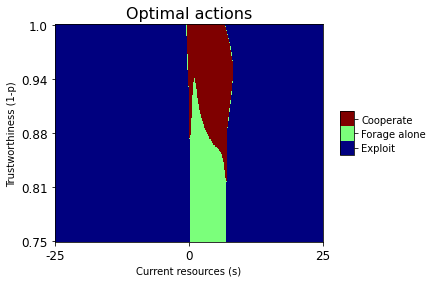

In [ ]:
# Modifiable parameters
P=np.arange(0,101)/400 # By default, we plot the optimal decisions for values of p going from 0 to 0.25
alpha = 1.2
r = 0.1
mu = 2
Sigma = 1
x = 1
gamma = 1/3
pi = 10
n = 5
beta = 5

#Create graph
optimal_decisions_policy_graph(title="Optimal actions",fontsize=12)


## Save an optimal action policy
This chunk saves an optimal action policy to a .csv file (e.g. to make figure 1 of the paper). 

In [ ]:
# Modifiable parameters
P=np.arange(0,101)/400 # By default, we plot the optimal decisions for values of p going from 0 to 0.25
alpha = 1.2
r = 0.1
mu = 2
Sigma = 1
x = 1
gamma = 1/3
pi = 10
n = 5
beta = 5

# Code
Decisions = np.empty(shape = (P.size,possible_states.size))
for i,j in enumerate(P):
    opt_dec = dyn_prog(p = j,T = 150)[0]
    Decisions[i,] = opt_dec

np.savetxt('figS3.csv', Decisions, delimiter=',')

## Population simulation

Now, we can simulate populations, then look at the dynamics. The first chunk of code creates a population with given parameters, which determines the rules of the game and the distribution of the level of resources in the population. With the given parameter values, you get a "virtuous circle": cooperation gradually spreads and trust increases. Increase Sigma or decrease mu and you may get a poverty trap instead (also takes longer to run). The next chunk makes a plot to visualize the evolution of the population.

In [ ]:
# Basic interaction parameters
alpha = 1.2
x = 1
gamma = 1/3
pi = 10
n = 5
beta = 5
r=0.1

# Population parameters
mu = 5.5
Sigma = 3
g = 100 # g is the number of groups, so population size N = g *n
K = 50 # the size of the sample observed by an agent to estimate p

P = Population() # Instantiate the class
P.populate(mu,Sigma,n,g) # Create the dudes in the population
for t in tqdm(range(10)): # Insert the number of rounds
    P.collective_game() # Make them play
    P.information_foraging() # Make them update their belief
    
#To save the resulting data, uncomment this line
#P.save_data_csv('simulation')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


The next chunk draws the plot. On the left side, we see the evolution of the behaviour frequencies, and on the right side, the dynamics of the resource states in the population, and of the level of social trust. We use heatmaps to plot the whole population instead of just the central tendency.

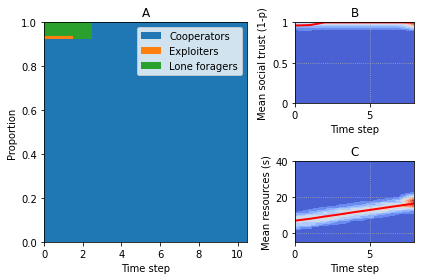

In [ ]:
P.plot()

## Sensitivity of optimal action policies to different parameter values
You can also make a multi-panel figure of optimal action policies for combinations of different parameter values: three levels each of alpha, r, pi and gamma. Warning: takes a long time to run, maybe 15 minutes.  

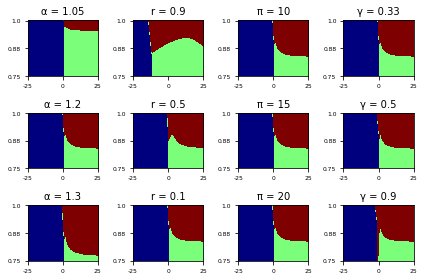

In [ ]:
## This block takes a long time to run (maybe 15min), be careful
gridspec.GridSpec(3,4)

ALPHA = [1.05,1.2,1.3]
for i,alpha in enumerate(ALPHA):
  optimal_decisions_policy_graph(gamma=1/3,r=.1,mu=2,pi=10,Sigma=1,x=1,alpha = alpha,title="α = "+str(alpha),fontsize=6,position=(i,0),grid=(3,4))
alpha=1.2
R = [1,0.8,0.1]
for i,r in enumerate(R):
  optimal_decisions_policy_graph(gamma=1/3,alpha=1.2,mu=2,pi=10,Sigma=1,x=1,r = r,title="r = "+str(r),fontsize=6,position=(i,1),grid=(3,4))
r=.1
PI = [10,15,20]
for i,pi in enumerate(PI):
  optimal_decisions_policy_graph(gamma=1/3,alpha=1.2,r=.1,mu=2,Sigma=1,x=1,pi=pi,title="π = "+str(pi),fontsize=6,position=(i,2),grid=(3,4))
pi=10
GAMMA = [.33,.5,.9]
for i,gamma in enumerate(GAMMA):
  optimal_decisions_policy_graph(alpha=1.2,r=.1,mu=2,pi=10,Sigma=1,x=1,gamma=gamma,title="γ = "+str(gamma),fontsize=6,position=(i,3),grid=(3,4))
gamma=1/3
plt.tight_layout()
plt.show()

@

In [ ]:
# Basic interaction parameters
alpha = 1.2
x = 1
gamma = 1/3
pi = 10
n = 5
beta = 5
r=0.1

# Population parameters
mu = 5.5
Sigma = 4
g = 100 
K = 50 

P = Population(endogenous_sigma=False) 
P.populate(mu,Sigma,n,g) 
for t in tqdm(range(10)):
    P.collective_game() 
    P.information_foraging()
  
Sigma=3 # Force a decrease 
for t in tqdm(range(10)):
    P.collective_game() 
    P.information_foraging()